# Saúde Bucal

## Acessando a população (P)

Acessando os dados de população por UF e faixa etária.


Carregando bibliotecas necessárias.

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

projecoes_tratadas = (
    pd.read_excel("projecoes_tratadas.xlsx")
    .assign(
        id_faixa_etaria=lambda d: d["faixa_etaria"].map({
            "00 a 14 anos": 1,
            "15 a 29 anos": 2,
            "30 a 59 anos": 3,
            "60 anos ou mais": 4
        })
    )
)
projecoes_tratadas.head()


,cod_uf,uf,ano,faixa_etaria,total,id_faixa_etaria
0,11,RO,2015,00 a 14 anos,423499,1
1,11,RO,2015,15 a 29 anos,450718,2
2,11,RO,2015,30 a 59 anos,648101,3
3,11,RO,2015,60 anos ou mais,144588,4
4,11,RO,2016,00 a 14 anos,418981,1


O gráfico abaixo mostra a evolução do quantitativo por faixa etária e UF.
Filtramos apenas as UF do Centro-Oeste.


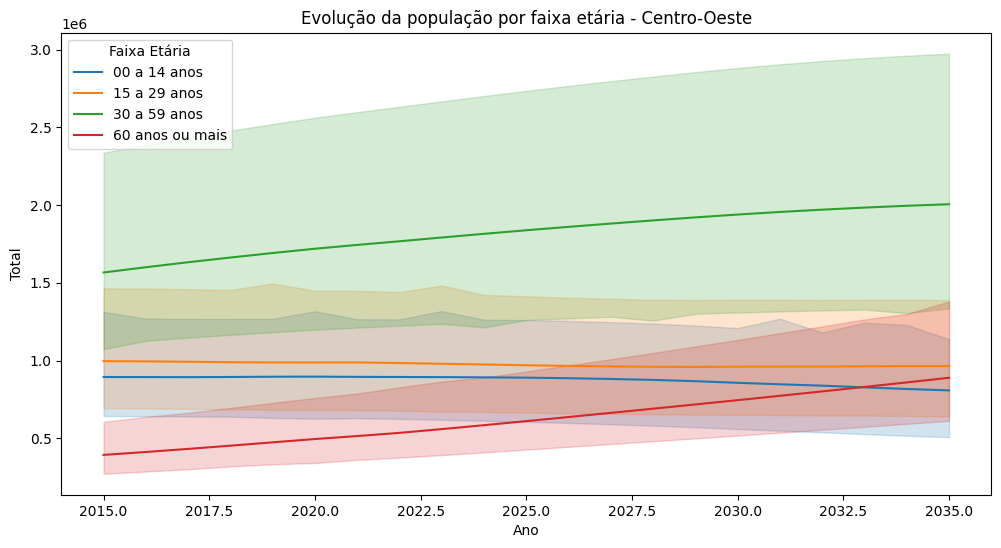

In [34]:
filtro = projecoes_tratadas.query("uf in ['GO', 'DF', 'MT', 'MS']")

plt.figure(figsize=(12,6))
sns.lineplot(data=filtro, x="ano", y="total", hue="faixa_etaria")
plt.title("Evolução da população por faixa etária - Centro-Oeste")
plt.xlabel("Ano")
plt.ylabel("Total")
plt.legend(title="Faixa Etária")
plt.show()


## Acessando a prevalência de condições (H)

Primeiramente, acessamos a prevalência de condições de saúde bucal (H).


In [35]:
cobertura = pd.read_csv("merge_sb_cobertura.csv")

cobertura_sb = (
    cobertura
    .drop(columns=["Unnamed: 0", "total_populacao", "faixa_etaria",
                   "erro_padrao", "IC_inf", "IC_sup"])
    .assign(
        perc_necessidade=lambda d: d["perc_necessidade"] / 100,
        cod_procedimento=lambda d: d["tipo_procedimento"].map({
            "Endodontia": 1,
            "Periodontia": 2,
            "APS": 3,
            "Prótese": 4
        })
    )
)
cobertura_sb.head()


,UF,cod_uf,cod_faixa,perc_necessidade,tipo_procedimento,cod_procedimento
0,Acre,12,1,0.600049,APS,3
1,Acre,12,2,0.738244,APS,3
2,Acre,12,3,0.716449,APS,3
3,Acre,12,4,0.326133,APS,3
4,Alagoas,27,1,0.472550,APS,3


O próximo passo consiste em juntar a base de população com a cobertura.


In [36]:
populacao_cobertura = (
    projecoes_tratadas
    .merge(cobertura_sb, left_on=["cod_uf", "id_faixa_etaria"],
                          right_on=["cod_uf", "cod_faixa"], how="left")
    .assign(necessidade_populacao=lambda d: d["total"] * d["perc_necessidade"])
)
populacao_cobertura.head()


,cod_uf,uf,ano,faixa_etaria,total,id_faixa_etaria,UF,cod_faixa,perc_necessidade,tipo_procedimento,cod_procedimento,necessidade_populacao
0,11,RO,2015,00 a 14 anos,423499,1,Rondônia,1,0.508139,APS,3,215196.358361
1,11,RO,2015,00 a 14 anos,423499,1,Rondônia,1,0.147070,Endodontia,1,62283.997930
2,11,RO,2015,00 a 14 anos,423499,1,Rondônia,1,0.000000,Periodontia,2,0.000000
3,11,RO,2015,00 a 14 anos,423499,1,Rondônia,1,0.000000,Prótese,4,0.000000
4,11,RO,2015,15 a 29 anos,450718,2,Rondônia,2,0.651960,APS,3,293850.107280


## Acessando a necessidade per capita (S)

O próximo passo consiste em juntar a base criada anteriormente com a base de necessidade por indivíduo (necessidade per capita).


In [37]:
percapita = (
    pd.read_csv("merge_sb_percapita.csv", sep=";")
    .drop(columns=["Unnamed: 0", "faixa_etaria", "se", "ic_inf",
                   "ic_sup", "UF", "total_populacao"])
    .assign(
        cod_procedimento=lambda d: d["tipo_procedimento"].map({
            "Endodontia": 1,
            "Periodontia": 2,
            "APS": 3,
            "Prótese": 4
        })
    )
    .drop(columns=["tipo_procedimento"])
)
percapita.head()


,cod_uf,cod_faixa,proc_per_capita,cod_procedimento
0,12,1,0.3598,1
1,12,2,0.2245,1
2,12,3,0.1455,1
3,12,4,0.1058,1
4,27,1,0.1410,1


O próximo passo é juntar todos os parâmetros (cobertura - H) e (procedimentos per capita - S).


In [ ]:
producao_completa = (
    populacao_cobertura
    .merge(
        percapita,
        left_on=["cod_uf", "id_faixa_etaria", "cod_procedimento"],
        right_on=["cod_uf", "cod_faixa", "cod_procedimento"],
        how="left"
    )
    .assign(
        necessidade_procedimentos=lambda d: d["necessidade_populacao"] * d["proc_per_capita"]
    )
    .rename(columns={
        "total": "populacao_total",
        "perc_necessidade": "necessidade_percentual",
        "proc_per_capita": "procedimentos_por_individuo",
        "necessidade_procedimentos": "total_procedimentos_necessario"
    })
    [["ano", "uf", "cod_uf", "faixa_etaria", "populacao_total", "tipo_procedimento",
      "necessidade_percentual", "necessidade_populacao", "procedimentos_por_individuo",
      "total_procedimentos_necessario"]]
 )
producao_completa.head()

,ano,uf,cod_uf,faixa_etaria,populacao_total,tipo_procedimento,necessidade_percentual,necessidade_populacao,procedimentos_por_individuo,total_procedimentos_necessario
0,2015,RO,11,00 a 14 anos,423499,APS,0.508139,215196.358361,1.5738,338676.028789
1,2015,RO,11,00 a 14 anos,423499,Endodontia,0.147070,62283.997930,0.3174,19768.940943
2,2015,RO,11,00 a 14 anos,423499,Periodontia,0.000000,0.000000,0.0000,0.000000
3,2015,RO,11,00 a 14 anos,423499,Prótese,0.000000,0.000000,0.0000,0.000000
4,2015,RO,11,15 a 29 anos,450718,APS,0.651960,293850.107280,2.0262,595399.087371


Incluir elementos sobre tempo de procedimento.


In [39]:
def funcao_tempo(t_aps, t_endo, t_periodontia, t_protese, ttd):
    df = producao_completa.copy()
    df["tempo_por_procedimento"] = df["tipo_procedimento"].map({
        "APS": t_aps,
        "Endodontia": t_endo,
        "Periodontia": t_periodontia,
        "Protese": t_protese
    })
    df["total_por_hora"] = df["tempo_por_procedimento"] * df["total_procedimentos_necessario"]
    df["fte40"] = df["total_por_hora"] / ttd
    return df

funcao_tempo(t_aps=0.5, t_endo=0.5, t_periodontia=0.5, t_protese=0.5, ttd=1500).head()


,ano,uf,cod_uf,faixa_etaria,populacao_total,tipo_procedimento,necessidade_percentual,necessidade_populacao,procedimentos_por_individuo,total_procedimentos_necessario,tempo_por_procedimento,total_por_hora,fte40
0,2015,RO,11,00 a 14 anos,423499,APS,0.508139,215196.358361,1.5738,338676.028789,0.5,169338.014394,112.892010
1,2015,RO,11,00 a 14 anos,423499,Endodontia,0.147070,62283.997930,0.3174,19768.940943,0.5,9884.470471,6.589647
2,2015,RO,11,00 a 14 anos,423499,Periodontia,0.000000,0.000000,0.0000,0.000000,0.5,0.000000,0.000000
3,2015,RO,11,00 a 14 anos,423499,Prótese,0.000000,0.000000,0.0000,0.000000,NaN,NaN,NaN
4,2015,RO,11,15 a 29 anos,450718,APS,0.651960,293850.107280,2.0262,595399.087371,0.5,297699.543685,198.466362
